In [28]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from torch.utils.data import DataLoader
from einops import rearrange
# from neuralop.models import FNO
from tqdm import tqdm

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.utils.download import well_download


### Notes:
- I could not find a way to download only a subset of the dataset, though you might be able to do this [with huggingface](https://huggingface.co/docs/datasets/loading#slice-splits)

In [3]:
# device = "cuda"
base_path = "./datasets"  # path/to/storage

In [92]:
# Download the active_matter train dataset from Hugging Face Hub
# The following line may take a couple of minutes to instantiate the datamodule
trainset = WellDataset(
    well_base_path="hf://datasets/polymathic-ai/",  # access from HF hub
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=81,
    n_steps_output=0,
)

KeyboardInterrupt: 

In [94]:
trainset[12424]['input_fields'].shape

torch.Size([10, 256, 256, 11])

In [80]:
len(trainset)

12425

In [81]:
type(trainset)

the_well.data.datasets.WellDataset

In [82]:
item = trainset[0]
type(item)

dict

In [83]:
list(item.keys())

['input_fields',
 'output_fields',
 'constant_scalars',
 'boundary_conditions',
 'space_grid',
 'input_time_grid',
 'output_time_grid']

The most important elements are `input_fields` and `output_fields`.

They represent the time-varying physical fields of the dynamical system and are generally the input and target of our models.

In [95]:
len(trainset)

12425

In [56]:
item["output_fields"].shape

torch.Size([1, 256, 256, 11])

In [57]:
# A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.
type(item["output_fields"])

torch.Tensor

In [58]:
# Get the tensor data type
item["output_fields"].dtype

torch.float32

In [59]:
trainset.metadata.field_names

{0: ['concentration'],
 1: ['velocity_x', 'velocity_y'],
 2: ['D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']}

In an item, the input and output form a time-contiguous window in the trajectories.

In [60]:
# Remove the first dimension for plotting
first_item_in = item["input_fields"][0]
first_item_out = item["output_fields"][0]

In [61]:
first_item_in.shape

torch.Size([256, 256, 11])

In [62]:
first_item_out.shape

torch.Size([256, 256, 11])

In [63]:
# Get the 256x256x1 concentration fields as a numpy arrays
conc_in = first_item_in[:, :, 0].numpy()
conc_out = first_item_out[:, :, 0].numpy()

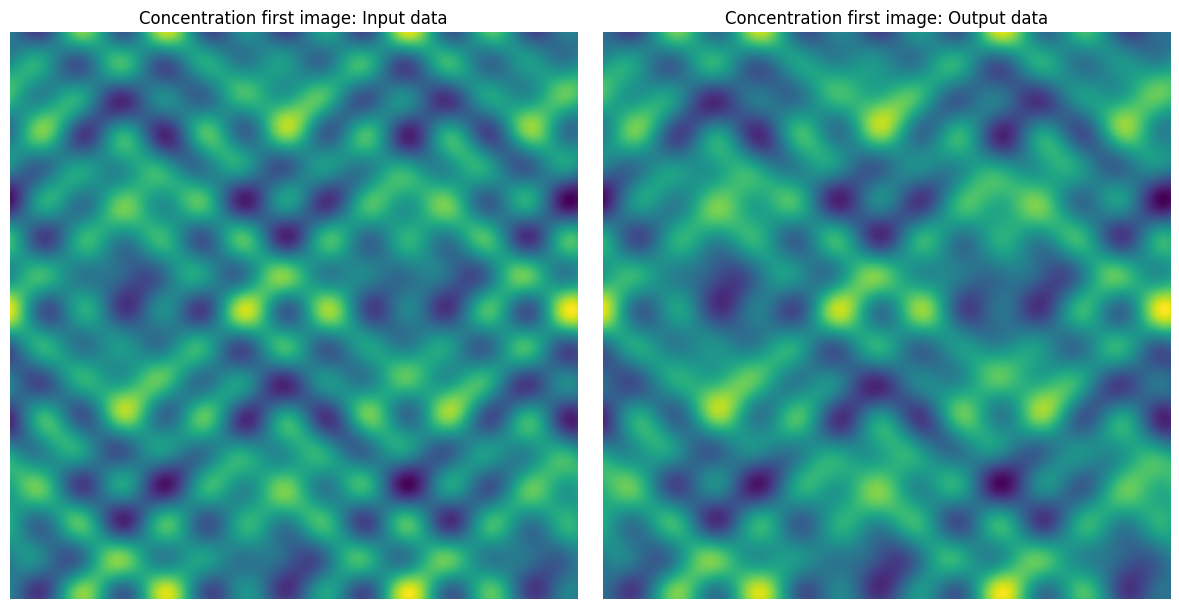

In [64]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Concentration first image: Input data")
plt.imshow(conc_in, cmap='viridis', origin="upper")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Concentration first image: Output data")
plt.imshow(conc_out, cmap='viridis', origin="upper")
plt.axis("off")
plt.tight_layout()
plt.show()

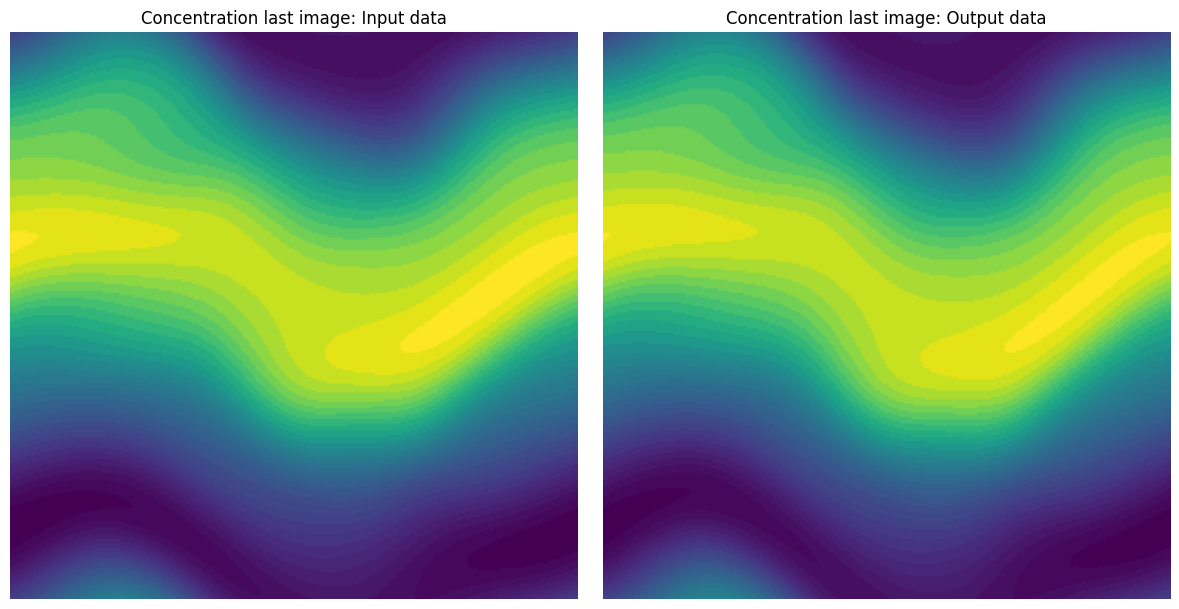

In [65]:
item = trainset[-1]
last_item_in = item["input_fields"][0]
last_item_out = item["output_fields"][0]
conc_in = last_item_in[:, :, 0].numpy()
conc_out = last_item_out[:, :, 0].numpy()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Concentration last image: Input data")
plt.imshow(conc_in, cmap='viridis', origin="upper")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Concentration last image: Output data")
plt.imshow(conc_out, cmap='viridis', origin="upper")
plt.axis("off")
plt.tight_layout()
plt.show()

In [96]:
item = trainset[0]

In [ ]:
item["input_fields"].shape  # dim 0 = time steps, 1 & 2 image row & column, 3 = fields

torch.Size([10, 256, 256, 11])

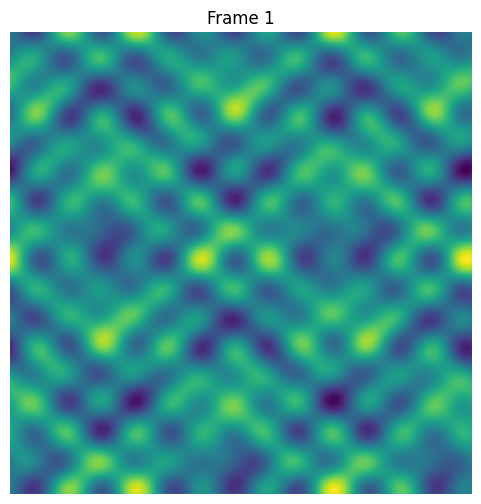

In [103]:
# Collect 20 evenly spaced `conc_in` arrays from the dataset
# concentration_frames = []
# num_frames = 20
# indices = np.linspace(0, len(trainset) - 1, num_frames, dtype=int)  # Get 20 evenly spaced indices

# for idx in indices:
item = trainset[0]
# item = trainset[idx]
item_in = item["input_fields"]
conc_in = item_in[:, :, :, 0].numpy()  # Extract the 256x256 slice
# concentration_frames.append(conc_in)

# Stack all frames into a single NumPy array
# concentration_frames_np = np.stack(concentration_frames, axis=0)  # Shape: (num_frames, 256, 256)

# conc_in.shape
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Concentration last image: Input data")
# plt.imshow(conc_in[0], cmap='viridis', origin="upper")
# plt.show()

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(conc_in[0], cmap='viridis', origin="upper")
ax.axis("off")
ax.set_title("Concentration Field Animation")

# Function to update the frame
def update(frame):
    img.set_data(conc_in[frame])
    ax.set_title(f"Frame {frame + 1}")
    return img,

# Create the animation
num_frames = conc_in.shape[0]
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=200)

# Display the animation using JavaScript
HTML(ani.to_jshtml())